<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0726/0726_07_1_(practice)Yolo_v3_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yolo_v3_implementation

## 2 way of shortcut connection
- identity shortcut connection
- projected shortcut connection

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

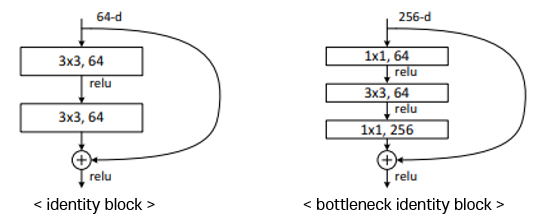

shortcut connection 시, 사용해야할 함수 : layers.Add()

In [ ]:
def conv_block(x, filters, kernel_size, strides=1, relu=True):
    x = tf.keras.layers.Conv2D(filters , kernel_size, strides, padding = 'same', activation='linear')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if relu:
        x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)

    return x

In [ ]:
def identity_block(inputs, filters, kernel_size, strides=1):
    x = conv_block(inputs, filters, kernel_size, strides=1, relu=True)
    x = conv_block(x, filters, kernel_size, strides=1, relu=False)
    x = tf.keras.layers.Add()([x, inputs])
    x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)
    return x

In [ ]:
def bottleneck_identity_block(inputs, filters, kernel_size, strides=1):
    # kernel_size : 1이라고 가정

    x = conv_block(inputs, filters, kernel_size, strides=1, relu=True)
    x = conv_block(x, filters, kernel_size*3, strides=1, relu=False)
    x = conv_block(x, filters, kernel_size, strides=1, relu=False)
    x = tf.keras.layers.Add()([x, inputs])
    x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)
    return x

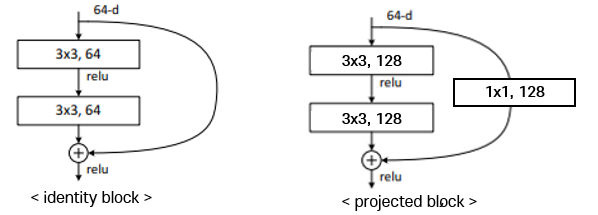

In [ ]:
def projection_block(inputs, filters, kernel_size, strides=1):
    x = conv_block(inputs, filters, kernel_size, strides=1, relu=True)
    x = conv_block(x, filters, kernel_size, strides=1, relu=False)
    p = conv_block(inputs, filters, 1, strides=1, relu=False)
    x = tf.keras.layers.Add()([x, p])
    x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)
    return x

## darknet-53

In [ ]:
def conv_block(x, filters, kernel_size, strides=1, activation=True):
    x = tf.keras.layers.Conv2D(filters , kernel_size, strides, padding = 'same', activation='linear')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if activation:
        x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)

    return x

def residual_block(inputs, filters, projected=False):
    x = conv_block(inputs, filters, 1, strides=1, activation=True)
    x = conv_block(x, filters*2, 3, strides=1, activation=False)

    if projected:
        p = conv_block(inputs, filters, 1, strides=1, activation=False)
        x = tf.keras.layers.Add()([x, p])
    else:
        x = tf.keras.layers.Add()([x, inputs])

    x = tf.keras.layers.LeakyReLU(alpha = 0.1)(x)

    return x


def darknet53(include_top=True, input_shape=(256, 256, 3), num_classes=1000):
    inputs = tf.keras.Input(shape=input_shape)

    # 1
    x = conv_block(inputs, 32, 3)
    x = conv_block(x, 64, 3, strides=2)

    # residual 1
    x = residual_block(x, 32, projected=False)

    # 2
    x = conv_block(x, 128, 3, strides=2)

    # # residual 2
    x = residual_block(x, 64, projected=False)
    x = residual_block(x, 64, projected=False)

    # 3
    x = conv_block(x, 256, 3, strides=2)

    # residual 3
    for i in  range(8):
        x = residual_block(x, 128, projected=False)
    route_1 = x

    # 4
    x = conv_block(x, 512, 3, strides=2)

    # residual 4
    for i in  range(8):
        x = residual_block(x, 256, projected=False)
    route_2 = x

    # 5
    x = conv_block(x, 1024, 3, strides=2)

    # residual 5
    for i in  range(4):
        x = residual_block(x, 512, projected=False)
    route_3 = x

    # out
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    if include_top:
        return model
    else:
        return tf.keras.Model(inputs = inputs, outputs = [route_1, route_2,route_3])

In [ ]:
darknet53 = darknet53()
darknet53.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_281 (Conv2D)            (None, 256, 256, 32  896         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_281 (Batch  (None, 256, 256, 32  128        ['conv2d_281[0][0]']             
 Normalization)                 )                                                           

## 강사님 코드

In [ ]:
def conv_block(x, filters, kernel_size, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
    x = layers.BatchNormalization()(x)
    return x

In [ ]:
def identity_block(inputs, filters, kernel_size, strides=1):
    shortcut = inputs

    x = conv_block(inputs, filters, 3)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = conv_block(x, filters, 3)

    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)

    return x

In [ ]:
def bottleneck_identity_block(inputs, filters, kernel_size, strides=1):
    shortcut = inputs

    x = conv_block(inputs, filters, 1)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = conv_block(x, filters, 3)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = conv_block(x, filters*4, 1)


    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)

    return x

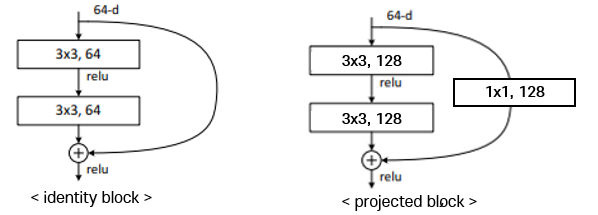

In [ ]:
def projection_block(inputs, filters, kernel_size, strides=1):
    shortcut = conv_block(inputs, filters, 1)

    x = conv_block(inputs, filters, 3)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = conv_block(x, filters, 3)

    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

### darknet-53

residual_block(inputs, filters, projected=False)

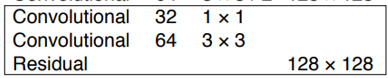

In [ ]:
def conv_block(x, filters, kernel_size, strides=1, activation=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(inputs, filters, projected=False):
    if projected:
        shortcut = conv_block(inputs, filters*2, 1, activation=False)
    else:
        shortcut = inputs

    x = conv_block(inputs, filters, 1)
    x = conv_block(x, filters*2, 3, activation=False)

    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x


def darknet53(include_top=True, input_shape=(256, 256, 3), num_classes=1000):
    inputs = tf.keras.Input(shape=input_shape)

    # Block 1
    x = conv_block(inputs, 32, 3)
    x = conv_block(x, 64, 3, 2)

    # Block 2
    x = residual_block(x, 32)
    x = conv_block(x, 128, 3, 2)

    # Block 3
    for _ in range(2):
        x = residual_block(x, 64)
    x = conv_block(x, 256, 3, 2)

    # Block 4
    for _ in range(8):
        x = residual_block(x, 128)
    route_1 = x
    x = conv_block(x, 512, 3, 2)

    # Block 5
    for _ in range(8):
        x = residual_block(x, 256)
    route_2 = x
    x = conv_block(x, 1024, 3, 2)

    # Block 6
    for _ in range(4):
        x = residual_block(x, 512)
    route_3 = x
     # Output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    if include_top:
        return model
    else:
        return tf.keras.Model(inputs=inputs, outputs=[route_1, route_2, route_3])

In [ ]:
darknet53 = darknet53()
darknet53.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_214 (Conv2D)            (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_214 (Batch  (None, 256, 256, 32  128        ['conv2d_214[0][0]']             
 Normalization)                 )                                                           

## Yolo v3

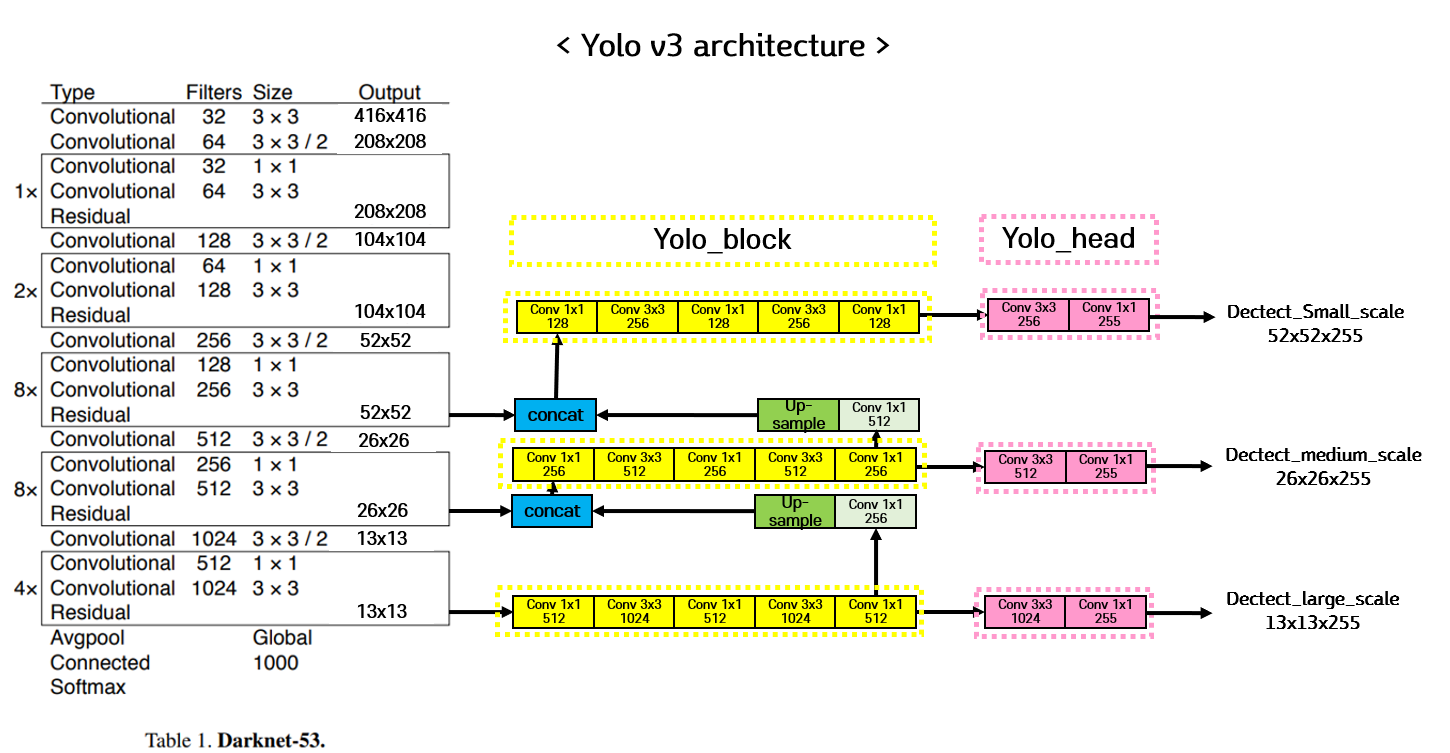

In [ ]:
# darknet backbone
# block 4 -> route 1
# block 5 -> route 2
# block 6 -> route 3


# yolo v3 architecture
# block 6 : route 3 -> yolo_block_1
# yolo_block_1
#    conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512

# yolo_head_1
#    conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    conv    255  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 255
#    detection

# yolo_block_1 -> conv -> upsample
#    conv    256  1 x 1 / 1    13 x  13 x 512   ->    13 x  13 x 256
#    upsample           * 2    13 x  13 x 256   ->    26 x  26 x 256
#    concat (route 2, upsample) -> yolo_block_2

# yolo_block_2
#    conv    256  1 x 1 / 1    26 x  26 x 768   ->    26 x  26 x 256
#    conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256

# yolo_head_2
#    conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    conv    255  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 255
#    detection

# yolo_block_2 -> conv -> upsample
#    conv    128  1 x 1 / 1    26 x  26 x 256   ->    26 x  26 x 128
#    upsample           * 2    26 x  26 x 128   ->    52 x  52 x 128
#    concat (route 1, upsample) -> yolo_block_3

# yolo_block_3
#    conv    128  1 x 1 / 1    52 x  52 x 384   ->    52 x  52 x 128
#    conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128

# yolo_head_3
#    conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    conv    255  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 255
#    detection

In [ ]:
num_anchors = 3
num_classes = 80

In [28]:
num_anchors = 3
num_classes = 80

def yolo_head(x, filters, num_anchors, num_classes):
    x = conv_block(x, filters, 3)

    # detection (Predictions Accross Scales)
    x = conv_block(x, num_anchors*(4+1+num_classes), 1)

    return x

def yolo_block(inputs, filters):
    x = conv_block(x, filters, 1)
    x = conv_block(x, filters*2, 3)
    x = conv_block(x, filters, 1)
    x = conv_block(x, filters*2, 3)
    x = conv_block(x, filters, 1)
    return x

def yolo_v3(input_shape, num_anchors, num_classes):
# # darknet backbone
#     darknet_53 = darknet53(include_top=False, input_shape=input_shape)
#     route_1, route_2, route_3 = darknet_53(inputs)

    inputs = tf.keras.Input(shape=input_shape)
# block 1
    x = conv_block(inputs, 32, 3)
    x = conv_block(x, 64, 3, strides=2, activation=False)
    x = residual_block(x, 32)

# block 2
    x = conv_block(x, 128, 3, strides=2, activation=False)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

# block 3 -> route 1
    x = conv_block(x, 256, 3, strides=2, activation=False)
    for i in range(8):
        x = residual_block(x, 128)

    route_1 = x

# block 4 -> route 2
    x = conv_block(x, 512, 3, strides=2, activation=False)
    for i in range(8):
        x = residual_block(x, 256)

    route_2 = x

# block 5 -> route 3
    x = conv_block(x, 1024, 3, strides=2, activation=False)
    for i in range(4):
        x = residual_block(x, 512)

    route_3 = x

# yolo v3 architecture
# block 6 : route 3 -> yolo_block_1
# yolo_block_1
    x = yolo_block(route_3, 512)

# yolo_head_1 >   detection
    output1 = yolo_head(x, 1024, num_anchors, num_classes)

# yolo_block_1 -> conv -> upsample
    x = yolo_block(x, 256)
    x = tf.keras.layers.UpSampling2D(2)(x)
    x = tf.concat([route_2, x], axis = -1)
# concat (route 2, upsample) -> yolo_block_2

# yolo_block_2
    x = yolo_block(x, 256)

# yolo_head_2
    output2 = yolo_head(x, 512, num_anchors, num_classes)

# yolo_block_2 -> conv -> upsample
    x = yolo_block(x, 128)
    x = tf.keras.layers.UpSampling2D(2)(x)
    x = tf.concat([route_1, x], axis = -1)
#    concat (route 1, upsample) -> yolo_block_3

# yolo_block_3
    x = yolo_block(x, 128)

# yolo_head_3
    output3 = yolo_head(x, 256, num_anchors, num_classes)

    model = tf.keras.Model(inputs=inputs, outputs=[output1, output2, output3])
    return model

### 강사님 코드

In [ ]:
# layer     filters    size              input                output
#     0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
#     1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
#     2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
#     3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
#     4 shortcut 1
#     5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
#     6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
#     7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
#     8 shortcut 5
#     9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
#    10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
#    11 shortcut 8
#    12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
#    13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    15 shortcut 12
#    16 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    17 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    18 shortcut 15
#    19 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    20 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    21 shortcut 18
#    22 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    23 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    24 shortcut 21
#    25 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    26 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    27 shortcut 24
#    28 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    29 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    30 shortcut 27
#    31 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    32 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    33 shortcut 30
#    34 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#    35 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#    36 shortcut 33
#    37 conv    512  3 x 3 / 2    52 x  52 x 256   ->    26 x  26 x 512
#    38 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    39 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    40 shortcut 37
#    41 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    42 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    43 shortcut 40
#    44 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    45 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    46 shortcut 43
#    47 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    48 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    49 shortcut 46
#    50 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    51 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    52 shortcut 49
#    53 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    54 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    55 shortcut 52
#    56 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    57 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    58 shortcut 55
#    59 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    60 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    61 shortcut 58
#    62 conv   1024  3 x 3 / 2    26 x  26 x 512   ->    13 x  13 x1024
#    63 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    64 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    65 shortcut 62
#    66 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    67 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    68 shortcut 65
#    69 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    70 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    71 shortcut 68
#    72 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    73 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    74 shortcut 71
#    75 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    76 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    77 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    78 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    79 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512
#    80 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024
#    81 conv    255  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 255
#    82 detection
#    83 route  79
#    84 conv    256  1 x 1 / 1    13 x  13 x 512   ->    13 x  13 x 256
#    85 upsample           * 2    13 x  13 x 256   ->    26 x  26 x 256
#    86 route  85 61
#    87 conv    256  1 x 1 / 1    26 x  26 x 768   ->    26 x  26 x 256
#    88 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    89 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    90 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    91 conv    256  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 256
#    92 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
#    93 conv    255  1 x 1 / 1    26 x  26 x 512   ->    26 x  26 x 255
#    94 detection
#    95 route  91
#    96 conv    128  1 x 1 / 1    26 x  26 x 256   ->    26 x  26 x 128
#    97 upsample           * 2    26 x  26 x 128   ->    52 x  52 x 128
#    98 route  97 36
#    99 conv    128  1 x 1 / 1    52 x  52 x 384   ->    52 x  52 x 128
#   100 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#   101 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#   102 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#   103 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
#   104 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
#   105 conv    255  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 255
#   106 detection

# 출처 : Deep Learning Bible - 4. Object Detection

In [ ]:
# 강사님 코드

def yolo_head(x, filters, num_anchors, num_classes):
    x = conv_block(x, filters, 3)

    # detection
    x = conv_block(x, num_anchors*(4+1+num_classes), 1)

    return x

def yolo_block(inputs, filters):
    x = conv_block(inputs, filters, 1)
    x = conv_block(x, filters*2, 3)
    x = conv_block(x, filters, 1)
    x = conv_block(x, filters*2, 3)
    x = conv_block(x, filters, 1)
    return x

def yolo_v3(input_shape=(416, 416, 3), num_anchors=3, num_classes=80):
    # backbone : darknet 53
    # - input : (416, 416, 3) image
    # - output : route1, route2, route3
    darknet_53 = darknet53(include_top=False, input_shape=(416, 416, 3))

    inputs = tf.keras.Input(shape=input_shape)
    route1, route2, route3 = darknet_53(inputs)

    # 13x13x255 detection
    x = yolo_block(route3, 512)
    output_l_scale = yolo_head(x, 1024, num_anchors, num_classes)

    # 26x26x255 detection
    x = conv_block(x, 256, 1)
    x = tf.keras.layers.UpSampling2D(2)(x)
    x = tf.keras.layers.Concatenate()([x, route2])
    x = yolo_block(x, 256)
    output_m_scale = yolo_head(x, 512, num_anchors, num_classes)

    # 52x52x255 detection
    x = conv_block(x, 128, 1)
    x = tf.keras.layers.UpSampling2D(2)(x)
    x = tf.keras.layers.Concatenate()([x, route1])
    x = yolo_block(x, 128)
    output_s_scale = yolo_head(x, 256, num_anchors, num_classes)

    outputs = [output_l_scale, output_m_scale, output_s_scale]
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model